# Our model

In [1]:
import zipfile
import os

# 定义路径
zip_file_path = 'landslide.zip'
extract_to_path = 'landslide'

# 创建解压路径，如果不存在的话
os.makedirs(extract_to_path, exist_ok=True)

# 打开zip文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 解压所有文件到指定路径
    zip_ref.extractall(extract_to_path)

print(f'Files have been extracted to {extract_to_path}')


Files have been extracted to landslide


2024-05-18 06:54:17.989935: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 06:54:24.147058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 06:54:24.742555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:27:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/si

Epoch 1/100


2024-05-18 06:54:35.580945: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-18 06:54:36.491820: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-18 06:54:36.491845: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-18 06:54:36.491931: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-18 06:54:37.184924: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


246/246 [==============================] - 46s 139ms/step - loss: 2.6921 - seg_output_loss: 2.1602 - edge_output_loss: 0.5319 - seg_output_accuracy: 0.7440 - edge_output_accuracy: 0.7732 - val_loss: 2.6752 - val_seg_output_loss: 2.1489 - val_edge_output_loss: 0.5263 - val_seg_output_accuracy: 0.7194 - val_edge_output_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 32s 130ms/step - loss: 2.2736 - seg_output_loss: 1.8582 - edge_output_loss: 0.4154 - seg_output_accuracy: 0.7300 - edge_output_accuracy: 0.7738 - val_loss: 2.5256 - val_seg_output_loss: 2.0385 - val_edge_output_loss: 0.4871 - val_seg_output_accuracy: 0.7432 - val_edge_output_accuracy: 0.7478
Epoch 3/100
246/246 [==============================] - 33s 133ms/step - loss: 2.1383 - seg_output_loss: 1.7443 - edge_output_loss: 0.3940 - seg_output_accuracy: 0.7881 - edge_output_accuracy: 0.8069 - val_loss: 2.5304 - val_seg_output_loss: 2.0476 - val_edge_output_loss: 0.4827 - val_seg_output_accuracy: 0.7593 - v

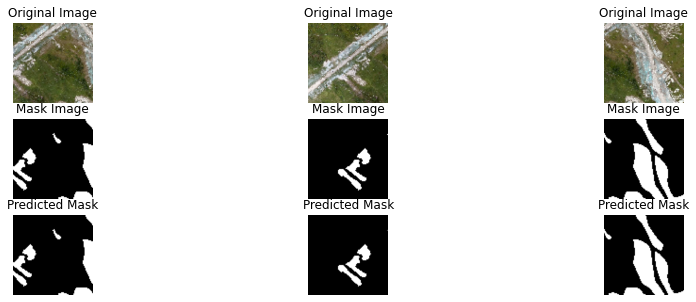

44/44 [==============================] - 9s 208ms/step
IoU: 0.7284301698837732
Dice coefficient: 0.8428808373388889
Accuracy: 0.9318718468071561
Precision: 0.8977850204876221
Recall: 0.7943046533372661
F1 Score: 0.8428806469314939
Overall Accuracy (OA): 18.273974757391784
Kappa coefficient: 0.7995944557349981


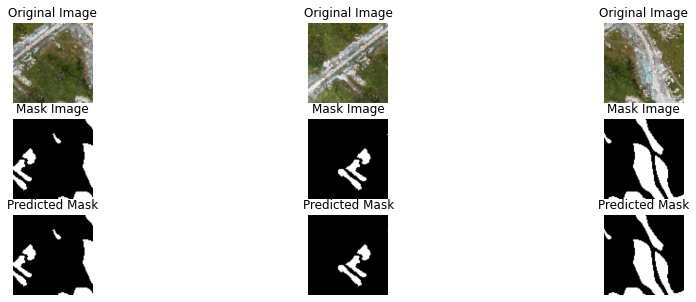

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def apply_crf(image, prediction):
    # 将预测结果转换为概率分布
    prediction = prediction.squeeze()  # 将 (256, 256, 1) 转换为 (256, 256)
    softmax = np.zeros((2, prediction.shape[0], prediction.shape[1]), dtype=np.float32)
    softmax[0, :, :] = 1 - prediction
    softmax[1, :, :] = prediction

    # 创建CRF模型
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], 2)

    # 将unary能量添加到CRF模型中
    unary = unary_from_softmax(softmax)
    d.setUnaryEnergy(unary)

    # 增加对比度和位置的一对一对特征
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
    d.addPairwiseEnergy(feats, compat=3)

    # 增加颜色特征
    feats = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)

    # 执行推理
    Q = d.inference(5)

    # 获得最终分割结果
    map = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

    return map

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)

    # 应用CRF后处理
    crf_preds = np.zeros(seg_preds_binary.shape[:3], dtype=np.float32)
    for i in range(images.shape[0]):
        crf_preds[i] = apply_crf(images[i].astype(np.uint8), seg_preds_binary[i])

    # 确保 masks 和 crf_preds 的形状匹配
    masks = masks.squeeze()  # 将 (770, 256, 256, 1) 转换为 (770, 256, 256)

    # 计算评估指标
    intersection = np.logical_and(masks, crf_preds)
    union = np.logical_or(masks, crf_preds)
    iou = np.sum(intersection) / np.sum(union)

    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(crf_preds))

    accuracy = accuracy_score(masks.flatten(), crf_preds.flatten())

    precision = precision_score(masks.flatten(), crf_preds.flatten())

    recall = recall_score(masks.flatten(), crf_preds.flatten())

    f1 = f1_score(masks.flatten(), crf_preds.flatten())

    oa = (intersection.sum() / masks.size) * 100

    kappa = cohen_kappa_score(masks.flatten(), crf_preds.flatten())

    return iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds

# 加载数据
data_path = 'landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)

# 可视化结果
plot_images(images, masks, crf_preds)


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 41s 134ms/step - loss: 2.6903 - seg_output_loss: 2.1849 - edge_output_loss: 0.5054 - seg_output_accuracy: 0.7675 - edge_output_accuracy: 0.7726 - val_loss: 2.8471 - val_seg_output_loss: 2.2590 - val_edge_output_loss: 0.5881 - val_seg_output_accuracy: 0.7621 - val_edge_output_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 32s 129ms/step - loss: 2.3844 - seg_output_loss: 1.9541 - edge_output_loss: 0.4303 - seg_output_accuracy: 0.7482 - edge_output_accuracy: 0.7733 - val_loss: 2.5847 - val_seg_output_loss: 2.0791 - val_edge_output_loss: 0.5057 - val_seg_output_accuracy: 0.7437 - val_edge_output_accuracy: 0.7621
Epoch 3/100
246/246 [==============================] - 32s 129ms/step - loss: 2.3134 - seg_output_loss: 1.9021 - edge_output_loss: 0.4113 - seg_output_accuracy: 0.7623 - edge_output_accuracy: 0.7733 - val_loss: 2.4670 - val_seg_output_loss: 1.9966 - val_edge_output_loss: 0.4704 - val_seg_output_accuracy

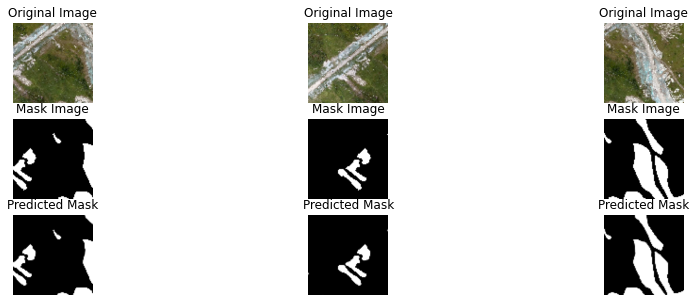

44/44 [==============================] - 9s 208ms/step
IoU: 0.7185232425634883
Dice coefficient: 0.8362098267036799
Accuracy: 0.927960416219714
Precision: 0.8766636556504288
Recall: 0.799325306425697
F1 Score: 0.8362100957001675
Overall Accuracy (OA): 1.8389481178534015
Kappa coefficient: 0.7901618938137984


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, seg_preds_binary)
    union = np.logical_or(masks, seg_preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(seg_preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), seg_preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, seg_preds_binary, edge_preds

# 加载数据
data_path = 'landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, seg_preds_binary, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# UNet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 14s 51ms/step - loss: 0.5500 - accuracy: 0.7733 - val_loss: 0.5194 - val_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 12s 47ms/step - loss: 0.4542 - accuracy: 0.7733 - val_loss: 0.5901 - val_accuracy: 0.7621
Epoch 3/100
246/246 [==============================] - 12s 47ms/step - loss: 0.4309 - accuracy: 0.7884 - val_loss: 0.5851 - val_accuracy: 0.7506
Epoch 4/100
246/246 [==============================] - 12s 48ms/step - loss: 0.4325 - accuracy: 0.8089 - val_loss: 0.5389 - val_accuracy: 0.7427
Epoch 5/100
246/246 [==============================] - 12s 47ms/step - loss: 0.4220 - accuracy: 0.8120 - val_loss: 0.5561 - val_accuracy: 0.7622
Epoch 6/100
246/246 [==============================] - 12s 47ms/step - loss: 0.3986 - accuracy: 0.8331 - val_loss: 0.5502 - val_accuracy: 0.7583
Epoch 7/100
246/246 [==============================] - 12s 48ms/step - loss: 0.3921 - accuracy: 0.8358 - val_loss: 0.6070 - val_ac

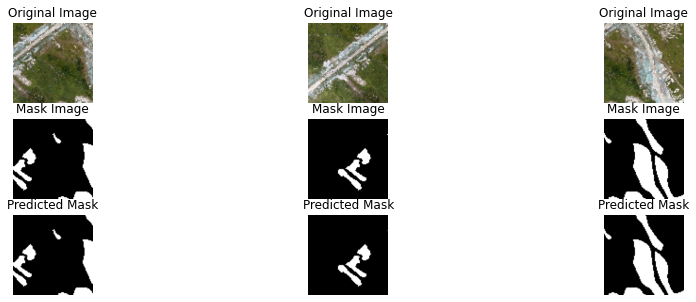

44/44 [==============================] - 4s 103ms/step
IoU: 0.7157846986258488
Dice coefficient: 0.834353158394033
Accuracy: 0.9292670779153386
Precision: 0.9045000249230177
Recall: 0.7743024630194643
F1 Score: 0.8343525842130566
Overall Accuracy (OA): 1.7813799282623597
Kappa coefficient: 0.7897287553309216


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score


def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)


def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


data_path = 'landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的UNet模型
unet_input = Input(shape=input_shape, name='unet_input')
unet_output = unet_model(input_shape)(unet_input)

combined_output = unet_output
combined_model = Model(inputs=unet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)


# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# FCN

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 11s 41ms/step - loss: 0.5468 - accuracy: 0.7673 - val_loss: 0.5201 - val_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 9s 38ms/step - loss: 0.4533 - accuracy: 0.7820 - val_loss: 0.5440 - val_accuracy: 0.7480
Epoch 3/100
246/246 [==============================] - 9s 38ms/step - loss: 0.4364 - accuracy: 0.8008 - val_loss: 0.5943 - val_accuracy: 0.7681
Epoch 4/100
246/246 [==============================] - 9s 38ms/step - loss: 0.4207 - accuracy: 0.8153 - val_loss: 0.6307 - val_accuracy: 0.7540
Epoch 5/100
246/246 [==============================] - 9s 38ms/step - loss: 0.4033 - accuracy: 0.8277 - val_loss: 0.5070 - val_accuracy: 0.7742
Epoch 6/100
246/246 [==============================] - 9s 38ms/step - loss: 0.3891 - accuracy: 0.8372 - val_loss: 0.5040 - val_accuracy: 0.7682
Epoch 7/100
246/246 [==============================] - 10s 40ms/step - loss: 0.3810 - accuracy: 0.8395 - val_loss: 0.6294 - val_accurac

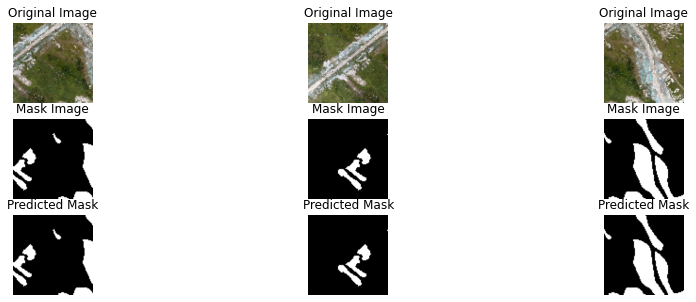

44/44 [==============================] - 3s 79ms/step
IoU: 0.7152666538658341
Dice coefficient: 0.834001190817322
Accuracy: 0.9287294722487685
Precision: 0.8984155832835702
Recall: 0.7782044455882245
F1 Score: 0.8340005354313631
Overall Accuracy (OA): 1.7903569285437657
Kappa coefficient: 0.7889209256549545


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def fcn_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 使用修改后的FCN模型
fcn_input = Input(shape=input_shape, name='fcn_input')
fcn_output = fcn_model(input_shape)(fcn_input)

combined_output = fcn_output
combined_model = Model(inputs=fcn_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)


predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# Segnet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 16s 57ms/step - loss: 0.5918 - accuracy: 0.7769 - val_loss: 0.5787 - val_accuracy: 0.7618
Epoch 2/100
246/246 [==============================] - 13s 53ms/step - loss: 0.4948 - accuracy: 0.8288 - val_loss: 0.5820 - val_accuracy: 0.7788
Epoch 3/100
246/246 [==============================] - 13s 54ms/step - loss: 0.4388 - accuracy: 0.8428 - val_loss: 0.4953 - val_accuracy: 0.7874
Epoch 4/100
246/246 [==============================] - 13s 55ms/step - loss: 0.4109 - accuracy: 0.8474 - val_loss: 1.1618 - val_accuracy: 0.7489
Epoch 5/100
246/246 [==============================] - 14s 55ms/step - loss: 0.3840 - accuracy: 0.8585 - val_loss: 0.5620 - val_accuracy: 0.7806
Epoch 6/100
246/246 [==============================] - 12s 50ms/step - loss: 0.3586 - accuracy: 0.8644 - val_loss: 0.4718 - val_accuracy: 0.7974
Epoch 7/100
246/246 [==============================] - 12s 50ms/step - loss: 0.3386 - accuracy: 0.8727 - val_loss: 0.6007 - val_ac

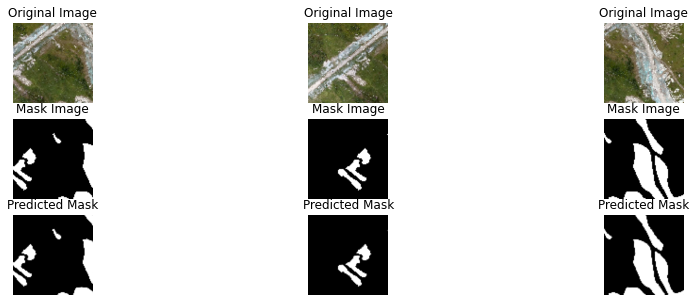

44/44 [==============================] - 4s 89ms/step
IoU: 0.7468023875861295
Dice coefficient: 0.8550505587212841
Accuracy: 0.9379472610103591
Precision: 0.9241871439182887
Recall: 0.7955383746753847
F1 Score: 0.8550507978388106
Overall Accuracy (OA): 1.8302358064093704
Kappa coefficient: 0.8158551915157977


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score


def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)


def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks
def segnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1, mask1 = MaxPooling2D(pool_size=(2, 2))(conv1), conv1
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2, mask2 = MaxPooling2D(pool_size=(2, 2))(conv2), conv2
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3, mask3 = MaxPooling2D(pool_size=(2, 2))(conv3), conv3
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4, mask4 = MaxPooling2D(pool_size=(2, 2))(conv4), conv4

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Concatenate()([mask4, conv5])

    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Concatenate()([mask3, conv6])

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Concatenate()([mask2, conv7])

    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Concatenate()([mask1, conv8])

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (256, 256, 3)

# 使用修改后的SegNet模型
segnet_input = Input(shape=input_shape, name='segnet_input')
segnet_output = segnet_model(input_shape)(segnet_input)

combined_output = segnet_output
combined_model = Model(inputs=segnet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# linknet

2024-05-18 12:15:37.024220: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 12:15:42.964754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 12:15:43.535451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:27:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/si

Epoch 1/100


2024-05-18 12:15:47.532968: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-18 12:15:48.303403: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-18 12:15:48.303422: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-18 12:15:48.303498: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


246/246 [==============================] - 19s 59ms/step - loss: 0.5275 - accuracy: 0.7943 - val_loss: 0.5425 - val_accuracy: 0.7603
Epoch 2/100
246/246 [==============================] - 13s 52ms/step - loss: 0.4593 - accuracy: 0.8295 - val_loss: 1.1931 - val_accuracy: 0.7336
Epoch 3/100
246/246 [==============================] - 12s 49ms/step - loss: 0.4187 - accuracy: 0.8430 - val_loss: 0.9568 - val_accuracy: 0.7593
Epoch 4/100
246/246 [==============================] - 12s 49ms/step - loss: 0.3935 - accuracy: 0.8481 - val_loss: 0.6351 - val_accuracy: 0.7729
Epoch 5/100
246/246 [==============================] - 12s 49ms/step - loss: 0.3755 - accuracy: 0.8558 - val_loss: 0.5104 - val_accuracy: 0.7674
Epoch 6/100
246/246 [==============================] - 12s 48ms/step - loss: 0.3612 - accuracy: 0.8562 - val_loss: 0.6069 - val_accuracy: 0.7768
Epoch 7/100
246/246 [==============================] - 12s 49ms/step - loss: 0.3304 - accuracy: 0.8656 - val_loss: 1.8548 - val_accuracy: 0.76

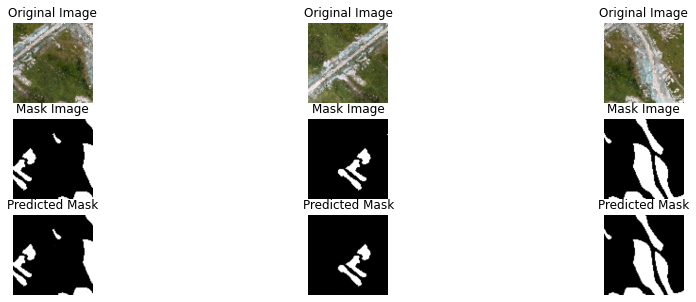

44/44 [==============================] - 4s 87ms/step
IoU: 0.7452057754871395
Dice coefficient: 0.8540026358050837
Accuracy: 0.9378159505324425
Precision: 0.9285559135593545
Recall: 0.7905324813958995
F1 Score: 0.854003334110134
Overall Accuracy (OA): 1.8187191210867846
Kappa coefficient: 0.8148211315025335


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def linknet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    up5 = Conv2D(512, 2, activation='relu', padding='same')(up5)
    merge5 = Concatenate()([conv4, up5])
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([conv3, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv2, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same')(up8)
    merge8 = Concatenate()([conv1, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load and prepare data
def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # Convert mask image to binary image
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

# Prepare dataset
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # Normalization
    return images, masks

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# Set data path
data_path = 'landslide'

# Load and prepare dataset
images, masks = prepare_dataset(data_path)

# Define input shape
input_shape = (256, 256, 3)

# Use modified LinkNet model
linknet_input = Input(shape=input_shape, name='linknet_input')
linknet_output = linknet_model(input_shape)(linknet_input)

combined_output = linknet_output
combined_model = Model(inputs=linknet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train combined model
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# Make predictions
predictions = combined_model.predict(images)

# Visualize results
plot_images(images, masks, predictions)

# Compute evaluation metrics
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# Deeplabv3

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 13s 38ms/step - loss: 0.5422 - accuracy: 0.7496 - val_loss: 0.6307 - val_accuracy: 0.7583
Epoch 2/100
246/246 [==============================] - 8s 31ms/step - loss: 0.4566 - accuracy: 0.7977 - val_loss: 0.6410 - val_accuracy: 0.7621
Epoch 3/100
246/246 [==============================] - 9s 36ms/step - loss: 0.4038 - accuracy: 0.8211 - val_loss: 0.7706 - val_accuracy: 0.7621
Epoch 4/100
246/246 [==============================] - 10s 39ms/step - loss: 0.3596 - accuracy: 0.8428 - val_loss: 0.8130 - val_accuracy: 0.7604
Epoch 5/100
246/246 [==============================] - 9s 36ms/step - loss: 0.3255 - accuracy: 0.8601 - val_loss: 1.1772 - val_accuracy: 0.7620
Epoch 6/100
246/246 [==============================] - 9s 37ms/step - loss: 0.3069 - accuracy: 0.8667 - val_loss: 0.7751 - val_accuracy: 0.7589
Epoch 7/100
246/246 [==============================] - 9s 36ms/step - loss: 0.2855 - accuracy: 0.8750 - val_loss: 0.6865 - val_accurac

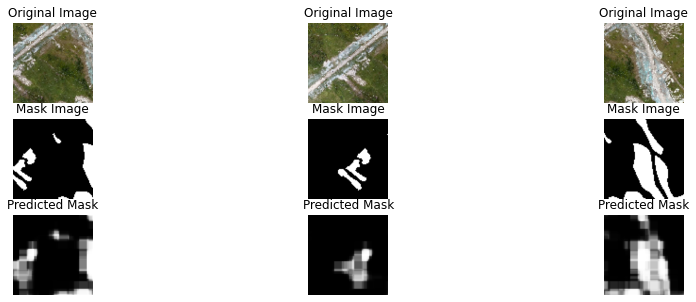

44/44 [==============================] - 1s 27ms/step
IoU: 0.6291644898336122
Dice coefficient: 0.7723771375270108
Accuracy: 0.9047698648101763
Precision: 0.8580159318043314
Recall: 0.702281738733878
F1 Score: 0.772376876318817
Overall Accuracy (OA): 1.6156872192905225
Kappa coefficient: 0.712923336863613


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import DepthwiseConv2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def deeplabv3_model(input_size=(256, 256, 3)):
    base_model = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')
    
    # Encoder部分
    inputs = Input(input_size)
    x = base_model(inputs)
    
    # Decoder部分
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)  # 输出掩模图像
    
    model = Model(inputs=inputs, outputs=x)
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # 计算IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # 计算Dice系数
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # 计算准确率
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # 计算精确率
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # 计算召回率
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # 计算F1分数
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # 总体准确率（OA）
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa系数
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

data_path = 'landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的DeepLabv3+模型
deeplabv3_input = Input(shape=input_shape, name='deeplabv3_input')
deeplabv3_output = deeplabv3_model(input_shape)(deeplabv3_input)

combined_output = deeplabv3_output[:, :256, :256, :]  # 裁剪输出以匹配输入尺寸
combined_model = Model(inputs=deeplabv3_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# VGG16+FCN

58889256/58889256 [==============================] - 62s 1us/step


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 11s 42ms/step - loss: 0.4729 - accuracy: 0.7893 - val_loss: 0.5718 - val_accuracy: 0.7490
Epoch 2/100
246/246 [==============================] - 10s 39ms/step - loss: 0.4128 - accuracy: 0.8127 - val_loss: 0.5231 - val_accuracy: 0.7335
Epoch 3/100
246/246 [==============================] - 10s 40ms/step - loss: 0.3805 - accuracy: 0.8271 - val_loss: 0.5496 - val_accuracy: 0.7548
Epoch 4/100
246/246 [==============================] - 10s 39ms/step - loss: 0.3588 - accuracy: 0.8396 - val_loss: 0.5101 - val_accuracy: 0.7499
Epoch 5/100
246/246 [==============================] - 10s 40ms/step - loss: 0.3405 - accuracy: 0.8483 - val_loss: 0.5409 - val_accuracy: 0.7501
Epoch 6/100
246/246 [==============================] - 10s 39ms/step - loss: 0.3275 - accuracy: 0.8548 - val_loss: 0.6024 - val_accuracy: 0.7328
Epoch 7/100
246/246 [==============================] - 10s 40ms/step - loss: 0.3323 - accuracy: 0.8535 - val_loss: 0.6853 - val_ac

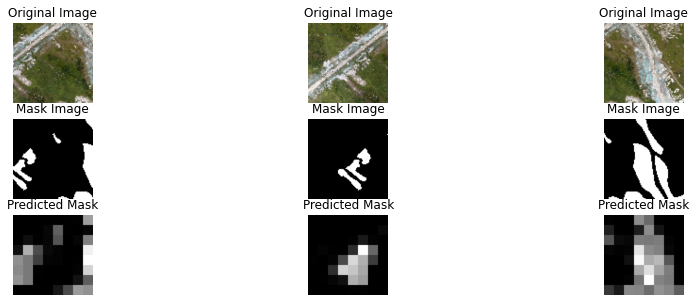

44/44 [==============================] - 2s 45ms/step
IoU: 0.5816005964451175
Dice coefficient: 0.7354584749919442
Accuracy: 0.8822727502667785
Precision: 0.761292541833005
Recall: 0.7113197563590768
F1 Score: 0.7354582411670194
Overall Accuracy (OA): 1.636480312374621
Kappa coefficient: 0.6598603640689008


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def vgg16_fcn(input_size=(256, 256, 3)):
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(vgg16_base.output)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    x = UpSampling2D(size=(32, 32))(x)

    model = Model(inputs=vgg16_base.input, outputs=x)
    return model

# 使用修改后的VGG16-FCN模型
input_shape = (256, 256, 3)
fcn_model = vgg16_fcn(input_shape)

fcn_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练FCN模型
fcn_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = fcn_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(fcn_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# PSPNet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 14s 51ms/step - loss: 0.5800 - accuracy: 0.7732 - val_loss: 0.5270 - val_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 12s 48ms/step - loss: 0.4457 - accuracy: 0.7770 - val_loss: 0.5084 - val_accuracy: 0.7493
Epoch 3/100
246/246 [==============================] - 12s 50ms/step - loss: 0.4250 - accuracy: 0.8139 - val_loss: 0.5257 - val_accuracy: 0.7656
Epoch 4/100
246/246 [==============================] - 12s 50ms/step - loss: 0.4115 - accuracy: 0.8248 - val_loss: 0.5167 - val_accuracy: 0.7701
Epoch 5/100
246/246 [==============================] - 14s 57ms/step - loss: 0.3976 - accuracy: 0.8328 - val_loss: 0.5323 - val_accuracy: 0.7677
Epoch 6/100
246/246 [==============================] - 13s 53ms/step - loss: 0.3973 - accuracy: 0.8334 - val_loss: 0.5860 - val_accuracy: 0.7613
Epoch 7/100
246/246 [==============================] - 13s 51ms/step - loss: 0.3864 - accuracy: 0.8394 - val_loss: 0.7018 - val_ac

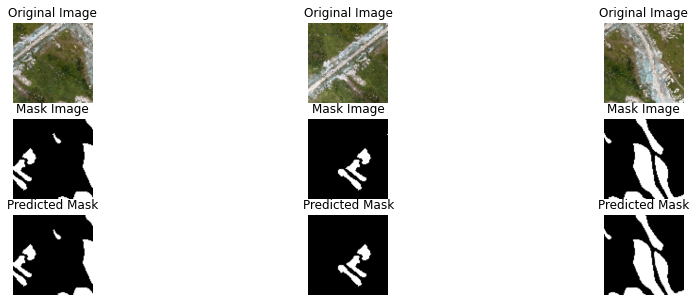

44/44 [==============================] - 4s 101ms/step
IoU: 0.7177189389150711
Dice coefficient: 0.8356653328933047
Accuracy: 0.9294380481845131
Precision: 0.9001186719984702
Recall: 0.7798253280686861
F1 Score: 0.8356651634386585
Overall Accuracy (OA): 1.7940859719792037
Kappa coefficient: 0.7910319270655033


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def pspnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # PSPNet Model
    # Your PSPNet model architecture implementation here
    # Replace this with the architecture of PSPNet
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

data_path = 'landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的PSPNet模型
pspnet_input = Input(shape=input_shape, name='pspnet_input')
pspnet_output = pspnet_model(input_shape)(pspnet_input)

combined_output = pspnet_output
combined_model = Model(inputs=pspnet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# FC-DenseNet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 9s 31ms/step - loss: 0.5028 - accuracy: 0.7719 - val_loss: 0.4891 - val_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 7s 29ms/step - loss: 0.4022 - accuracy: 0.7941 - val_loss: 0.4626 - val_accuracy: 0.7604
Epoch 3/100
246/246 [==============================] - 7s 30ms/step - loss: 0.3763 - accuracy: 0.8228 - val_loss: 0.5561 - val_accuracy: 0.7579
Epoch 4/100
246/246 [==============================] - 8s 33ms/step - loss: 0.3734 - accuracy: 0.8239 - val_loss: 0.5336 - val_accuracy: 0.7495
Epoch 5/100
246/246 [==============================] - 7s 29ms/step - loss: 0.3620 - accuracy: 0.8343 - val_loss: 0.5072 - val_accuracy: 0.7600
Epoch 6/100
246/246 [==============================] - 7s 29ms/step - loss: 0.3634 - accuracy: 0.8313 - val_loss: 0.4813 - val_accuracy: 0.7563
Epoch 7/100
246/246 [==============================] - 7s 29ms/step - loss: 0.3512 - accuracy: 0.8400 - val_loss: 0.5092 - val_accuracy:

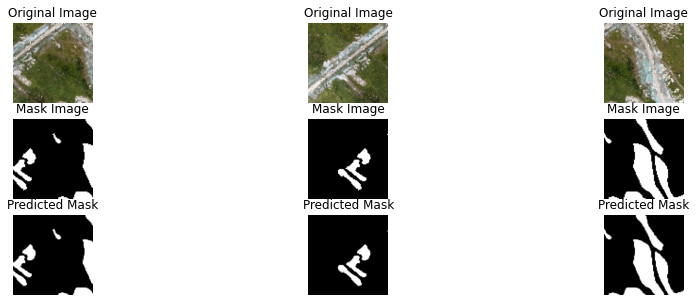

44/44 [==============================] - 3s 64ms/step
IoU: 0.7392569890395084
Dice coefficient: 0.8500839155677941
Accuracy: 0.935800843504118
Precision: 0.918486092378727
Recall: 0.7911633686141651
F1 Score: 0.8500836779132422
Overall Accuracy (OA): 1.8201705562575228
Kappa coefficient: 0.8095262815641029


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def fcdensenet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # FC-DenseNet Model
    # Encoder
    conv1 = Conv2D(48, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(48, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(96, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(96, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(192, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(192, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(384, 3, activation='relu', padding='same')(pool3)

    # Decoder
    up1 = Conv2D(192, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(192, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(192, 3, activation='relu', padding='same')(conv5)

    up2 = Conv2D(96, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(96, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(96, 3, activation='relu', padding='same')(conv6)

    up3 = Conv2D(48, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(48, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(48, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

data_path = 'landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的FC-DenseNet模型
fcdensenet_input = Input(shape=input_shape, name='fcdensenet_input')
fcdensenet_output = fcdensenet_model(input_shape)(fcdensenet_input)

combined_output = fcdensenet_output
combined_model = Model(inputs=fcdensenet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Attention Gate Model

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
246/246 [==============================] - 21s 75ms/step - loss: 0.4522 - accuracy: 0.7858 - val_loss: 0.5326 - val_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 18s 72ms/step - loss: 0.3979 - accuracy: 0.8100 - val_loss: 0.4902 - val_accuracy: 0.7618
Epoch 3/100
246/246 [==============================] - 17s 70ms/step - loss: 0.3819 - accuracy: 0.8204 - val_loss: 0.4895 - val_accuracy: 0.7615
Epoch 4/100
246/246 [==============================] - 17s 70ms/step - loss: 0.3756 - accuracy: 0.8237 - val_loss: 0.5205 - val_accuracy: 0.7645
Epoch 5/100
246/246 [==============================] - 18s 71ms/step - loss: 0.3691 - accuracy: 0.8283 - val_loss: 0.4963 - val_accuracy: 0.7562
Epoch 6/100
246/246 [==============================] - 17s 69ms/step - loss: 0.3830 - accuracy: 0.8247 - val_loss: 0.5007 - val_accuracy: 0.7708
Epoch 7/100
246/246 [==============================] - 18s 73ms/step - loss: 0.3584 - accuracy: 0.8364 - val_loss: 0.5345 - val_ac

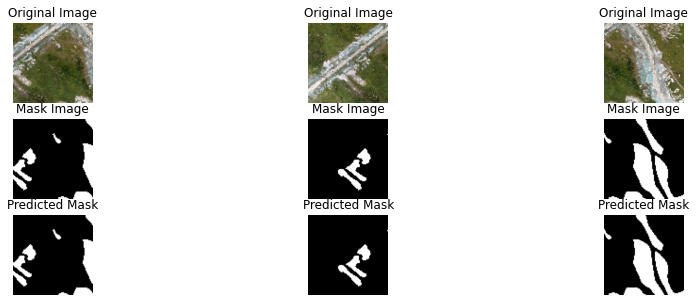

44/44 [==============================] - 6s 139ms/step
IoU: 0.7562506875707216
Dice coefficient: 0.8612110451663288
Accuracy: 0.9405818944650778
Precision: 0.930803016504919
Recall: 0.8013002350925338
F1 Score: 0.8612104102481878
Overall Accuracy (OA): 1.8434916889446438
Kappa coefficient: 0.8236782798255693


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Activation, multiply, add
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unet_with_attention_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # U-Net with Attention Gate Model
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)

    # Decoder with Attention Gate
    up1 = UpSampling2D(size=(2, 2))(conv4)
    attention1 = attention_gate(conv3, up1)
    merge1 = concatenate([conv3, attention1], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    attention2 = attention_gate(conv2, up2)
    merge2 = concatenate([conv2, attention2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    attention3 = attention_gate(conv1, up3)
    merge3 = concatenate([conv1, attention3], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def attention_gate(up, down):
    up = Conv2D(filters=down.shape[-1], kernel_size=(3, 3), padding='same')(up)
    up = BatchNormalization(axis=3)(up)
    up = Activation('relu')(up)
    up = Conv2D(filters=down.shape[-1], kernel_size=(3, 3), padding='same')(up)
    up = BatchNormalization(axis=3)(up)
    up = Activation('sigmoid')(up)

    return multiply([up, down])

data_path = 'landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的U-Net with Attention Gate模型
unet_input = Input(shape=input_shape, name='unet_input')
unet_output = unet_with_attention_model(input_shape)(unet_input)

combined_output = unet_output
combined_model = Model(inputs=unet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Squeeze and Excitation Blocks (UNetSE)

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
  3/246 [..............................] - ETA: 10s - loss: 0.7468 - accuracy: 0.7369 

2024-05-18 14:44:21.465051: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


246/246 [==============================] - 14s 50ms/step - loss: 0.5434 - accuracy: 0.7729 - val_loss: 0.5387 - val_accuracy: 0.7621
Epoch 2/100
246/246 [==============================] - 12s 49ms/step - loss: 0.4482 - accuracy: 0.7920 - val_loss: 0.5065 - val_accuracy: 0.7691
Epoch 3/100
246/246 [==============================] - 12s 49ms/step - loss: 0.4272 - accuracy: 0.8127 - val_loss: 0.5994 - val_accuracy: 0.7645
Epoch 4/100
246/246 [==============================] - 12s 49ms/step - loss: 0.4133 - accuracy: 0.8221 - val_loss: 0.5870 - val_accuracy: 0.7753
Epoch 5/100
246/246 [==============================] - 12s 49ms/step - loss: 0.4018 - accuracy: 0.8266 - val_loss: 0.5446 - val_accuracy: 0.7697
Epoch 6/100
246/246 [==============================] - 12s 49ms/step - loss: 0.3960 - accuracy: 0.8297 - val_loss: 0.5311 - val_accuracy: 0.7599
Epoch 7/100
246/246 [==============================] - 12s 48ms/step - loss: 0.3922 - accuracy: 0.8381 - val_loss: 0.5923 - val_accuracy: 0.76

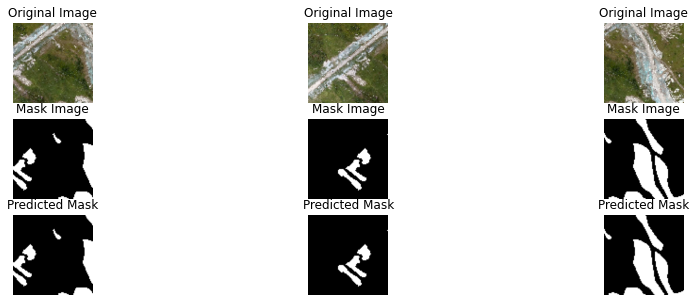

44/44 [==============================] - 4s 101ms/step
IoU: 0.7114137746849019
Dice coefficient: 0.8313761322735713
Accuracy: 0.9279907052425107
Precision: 0.9011974289399353
Recall: 0.771594842298301
F1 Score: 0.8313755389936421
Overall Accuracy (OA): 1.7751507072067805
Kappa coefficient: 0.7859449071004736


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unetse_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # UNet with Squeeze and Excitation Blocks (UNetSE) Model
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # 添加Squeeze and Excitation Block
    squeeze = GlobalAveragePooling2D()(conv9)
    excitation = Dense(64, activation='relu')(squeeze)
    excitation = Dense(64, activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, 64))(excitation)
    conv9 = Multiply()([conv9, excitation])

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 加载数据
data_path = 'landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNetSE模型
input_shape = (256, 256, 3)
unetse_input = Input(shape=input_shape, name='unetse_input')
unetse_output = unetse_model(input_shape)(unetse_input)
combined_model = Model(inputs=unetse_input, outputs=unetse_output)
combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Dilated Convolutions (UNetDC)

2024-05-18 18:13:17.008332: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 18:13:23.770449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 18:13:24.428875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:d8:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/si

Epoch 1/100


2024-05-18 18:13:28.519195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-18 18:13:29.304925: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-18 18:13:29.304947: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-18 18:13:29.304997: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


246/246 [==============================] - 18s 52ms/step - loss: 0.4925 - accuracy: 0.7748 - val_loss: 0.4975 - val_accuracy: 0.7764
Epoch 2/100
246/246 [==============================] - 12s 48ms/step - loss: 0.3950 - accuracy: 0.8102 - val_loss: 0.5049 - val_accuracy: 0.7640
Epoch 3/100
246/246 [==============================] - 11s 44ms/step - loss: 0.3839 - accuracy: 0.8152 - val_loss: 0.4595 - val_accuracy: 0.7669
Epoch 4/100
246/246 [==============================] - 11s 46ms/step - loss: 0.3601 - accuracy: 0.8358 - val_loss: 0.4745 - val_accuracy: 0.7700
Epoch 5/100
246/246 [==============================] - 12s 47ms/step - loss: 0.3657 - accuracy: 0.8286 - val_loss: 0.4652 - val_accuracy: 0.7661
Epoch 6/100
246/246 [==============================] - 11s 45ms/step - loss: 0.3523 - accuracy: 0.8398 - val_loss: 0.4844 - val_accuracy: 0.7724
Epoch 7/100
246/246 [==============================] - 12s 51ms/step - loss: 0.3307 - accuracy: 0.8520 - val_loss: 0.4785 - val_accuracy: 0.76

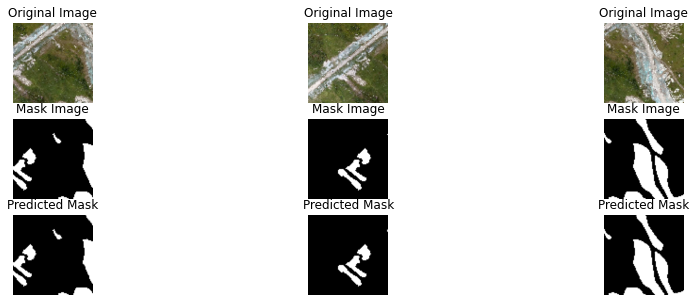

44/44 [==============================] - 4s 93ms/step
IoU: 0.7323443890733546
Dice coefficient: 0.845495085393411
Accuracy: 0.9334189922425274
Precision: 0.9069357746388518
Recall: 0.7918509770212955
F1 Score: 0.8454951494547707
Overall Accuracy (OA): 1.8217524856371479
Kappa coefficient: 0.8033096056241542


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose, Cropping2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unetdc_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # UNet with Dilated Convolutions (UNetDC) Model
    conv1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5)

    up6 = concatenate([Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 加载数据
data_path = 'landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNetDC模型
input_shape = (256, 256, 3)
unetdc_input = Input(shape=input_shape, name='unetdc_input')
unetdc_output = unetdc_model(input_shape)(unetdc_input)
combined_model = Model(inputs=unetdc_input, outputs=unetdc_output)
combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)
